# Final Project_PoWen_Hsu_ph2660

#### The primary goal of this project is to utilize web scraping to find a user's ideal job listings on LinkedIn, extract job descriptions, qualifications, and responsibilities, analyze the most significant keywords through word clouds, and use the insights gained to customize a resume for specific job applications.

In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver
from bs4 import BeautifulSoup
import re as re
import time
import pandas as pd

In [2]:
# I stored my LinkedIn account and password in api_keys file
import api_keys
# This will make sure the file gets reloaded if you add more api keys
from importlib import reload
reload(api_keys)

<module 'api_keys' from '/Users/powenhsu/Dropbox/Mac (2)/Desktop/My place/Academic/Master/04. Columbia- Applied Analytics/4_2023 Fall/#8154 Python for MBAs/api_keys.py'>

## 1. Web scraping LinkedIn to extract jobs information

#### Reference: 
[How to build a Web Scraper for LinkedIn](https://medium.com/mlearning-ai/how-to-build-a-web-scraper-for-linkedin-6b49b6b6adfc)

[Web Scraping Linkedin Job Page with Selenium Python](https://medium.com/@kurumert/web-scraping-linkedin-job-page-with-selenium-python-e0b6183a5954)

In [3]:
# Store the username and password in another file for safty reason
USERNAME = api_keys.linkedin_username 
PASSWORD = api_keys.linkedin_password

In [4]:
# Initialize web driver that Selenium will use to carry out all the operations
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

In [5]:
# Tell our browser the link it should fetch
driver.get("https://www.linkedin.com/uas/login")
time.sleep(2)

In [6]:
# Tell the driver to login with the credentials we’ve provided
email=driver.find_element(By.ID, "username")
email.send_keys(USERNAME)
password=driver.find_element(By.ID, "password")
password.send_keys(PASSWORD)
time.sleep(2)
password.send_keys(Keys.RETURN)

In [9]:
# Navigate to the Job Search Page
job_title = 'Data Analyst'
location = 'New York'
driver.get(f"https://www.linkedin.com/jobs/search/?keywords={job_title}&location={location}")

In [21]:
jobs_block = driver.find_element(By.CLASS_NAME,'jobs-search-results-list')
jobs_list = jobs_block.find_elements(By.CSS_SELECTOR, '.jobs-search-results__list-item')

In [9]:
jobs_list

[<selenium.webdriver.remote.webelement.WebElement (session="c3b387e137311a95030ff4a5ff914748", element="A37D378025377A888055988C1544F7E4_element_511")>,
 <selenium.webdriver.remote.webelement.WebElement (session="c3b387e137311a95030ff4a5ff914748", element="A37D378025377A888055988C1544F7E4_element_530")>,
 <selenium.webdriver.remote.webelement.WebElement (session="c3b387e137311a95030ff4a5ff914748", element="A37D378025377A888055988C1544F7E4_element_549")>,
 <selenium.webdriver.remote.webelement.WebElement (session="c3b387e137311a95030ff4a5ff914748", element="A37D378025377A888055988C1544F7E4_element_568")>,
 <selenium.webdriver.remote.webelement.WebElement (session="c3b387e137311a95030ff4a5ff914748", element="A37D378025377A888055988C1544F7E4_element_587")>,
 <selenium.webdriver.remote.webelement.WebElement (session="c3b387e137311a95030ff4a5ff914748", element="A37D378025377A888055988C1544F7E4_element_606")>,
 <selenium.webdriver.remote.webelement.WebElement (session="c3b387e137311a95030ff4

In [11]:
links = []

for job in jobs_list:
    all_links = job.find_elements(By.TAG_NAME,'a')
    for a in all_links:
        if str(a.get_attribute('href')).startswith("https://www.linkedin.com/jobs/view") and a.get_attribute('href') not in links: 
            links.append(a.get_attribute('href'))
        else:
            pass

In [11]:
links

['https://www.linkedin.com/jobs/view/3730007686/?eBP=CwEAAAGLRcb0eMlIeH8cvLs1-XU_V7qtGGtchwZ_QIriStyY_L06ty-2_wJ_2WEsF-_k8M3u_uShKU9aljK-2BeHnJPKh96wKyEaf8tiHQRYV0eMbSG_2IxGG1XEc-DtHUJrXO5oWaInOjNR9z2-16Hc3qihM-ugLGjKbW1YMjl2WMtLSb0q0GR8qI7b5Cn5khNZIyXgg0vQZzEv1RRA3Jie3XxyT5tHpGNK-gwcewsZPRtfkbYarWSPd3uSy3dlDXpCP3ieS3ToESjBDb_APAndmCfQh_cLoMsNjRsyOdZzMBAkV1z0UNLyrFrt46VRZiM0snpYLML7WpJt_HZZP60YN7QGJGLObpkMgC9KZmQs7ldpdGEQu19n_LZzF0Vag4W7uu_q&refId=auQTiFdqG2vS4ct8YjFxzw%3D%3D&trackingId=x4SxHq19V66b6vE3xFEnkg%3D%3D&trk=flagship3_search_srp_jobs',
 'https://www.linkedin.com/jobs/view/3680021099/?eBP=CwEAAAGLRcb0eVAuz-ZhSe6GnsPbhcwline-u2l2jvQ9WzMgziukXtgRY_mR465AdvBmh3q1DVMLIEJhmn2ndZ3emQ6KwIcKju__Y6k5Jgax3tRwUeXshznAqAmIcqnZfETvTbSyWigngz8b2KzTAraWLzWMPwzbws5XDLN3CLqDauxTkj4yIegLBReDGZbByvBSEAOJrtBrIZK5uLsLok8IerRDW5vYgtIYArI3KssyuBPkQDdLos3AVCb_1XBHs_SCRFqPMaGJNvrdbLB2ZiVSBwGIlI_rs6SdIiuYJs0pG2spbFsWSHcUv05cukop6JV3bHjIa_LLsHQjVIJgGRIPLQB42Wn3xT0gYnlJYqOhf5IZFiYyFIUarzu4qJJ93E7w0rAv&r

In [18]:
# Create empty lists to store information
job_titles = []
company_names = []
company_location_dayPosted_applicantsCount = []
job_desc = []

i = 0
j = 1

# Visit each link one by one to scrape the information
print('Visiting the links and collecting information just started.')

for i in range(len(links)):
    try:
        driver.get(links[i])
        i=i+1
        time.sleep(2)
        # Click the See more button
        driver.find_element(By.CLASS_NAME,'artdeco-card__action').click()
        time.sleep(2)
    except:
        pass
    
    # Find the general information of the job offer
    # Used try, except in case there is some missing information for some of the job offers
    contents = driver.find_elements(By.CLASS_NAME,'p5')
    for content in contents:
        try:
            job_titles.append(content.find_element(By.TAG_NAME,'h1').text)
            company_names.append(content.find_element(By.CLASS_NAME,'job-details-jobs-unified-top-card__job-title').text)
            company_location_dayPosted_applicantsCount.append(content.find_element(By.CLASS_NAME,'job-details-jobs-unified-top-card__primary-description').text)
            print(f'Scraping the Job Offer {j} DONE.')
            j+= 1

        except:
            pass
        time.sleep(2)

        # Scraping the job description
    job_description = driver.find_element(By.CLASS_NAME, 'jobs-description__content')
    for description in job_description:
        job_text = job_description.find_element(By.CLASS_NAME, 'jobs-box__html-content').text
        job_desc.append(job_text)
        print(f'Scraping the Job Offer {j}')
        time.sleep(2) 
    job_description = driver.find_element(By.CLASS_NAME, 'jobs-description__content')
    for description in job_description:
        job_text = description.find_element(By.CLASS_NAME'jobs-box__html-content').text
        job_desc.append(job_text)
        print(f'Scraping the Job Offer {j}')
        time.sleep(2) 

Visiting the links and collecting information just started.
Scraping the Job Offer 1 DONE.
Scraping the Job Offer 2
Scraping the Job Offer 2 DONE.
Scraping the Job Offer 3
Scraping the Job Offer 3 DONE.
Scraping the Job Offer 4
Scraping the Job Offer 4 DONE.
Scraping the Job Offer 5
Scraping the Job Offer 5 DONE.
Scraping the Job Offer 6
Scraping the Job Offer 6 DONE.
Scraping the Job Offer 7
Scraping the Job Offer 7 DONE.
Scraping the Job Offer 8


In [16]:
# Creating the dataframe 
df = pd.DataFrame(list(zip(job_titles, company_location_dayPosted_applicantsCount)),
 columns =['job_title', 'company_location_dayPosted_applicantsCount'])
df

,job_title,company_location_dayPosted_applicantsCount
0,Data Analyst,"TickPick · New York, United States Reposted 2..."
1,Senior Quality Data Analyst,"MetroPlusHealth · New York, NY 2 weeks ago ·..."
2,"Sr. Analyst, Website Analytics","Publicis Digital Experience · New York, NY 2 ..."
3,Tableau/Alteryx Consultant,"The Data School New York · New York, NY Repost..."
4,Data Governance Analyst - I,Freedom Mortgage · United States 3 hours ago ...
5,Data Analyst,"Gallagher · New York, NY Reposted 2 weeks ago..."
6,"Senior Analyst, Data & Tech","Initiative · New York, NY 3 weeks ago · 531 ..."


In [17]:
# Since the job description length doesn't fit the dataframe, I store it seperately
# Check the number of jub description
len(job_desc)

7

## 2. Conduct text analysis to know the key words of the position

In [18]:
# Output job descriptions

# Adjust n to choose which job discription to look at
n = 0
text = job_desc[0]

In [19]:
# Cleaning the text

import re

def clean_text(text):
    # Remove special characters, punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespaces
    text = ' '.join(text.split())
    # Convert the text to lowercase
    text = text.lower()
    return text

text_cleaned = clean_text(text)
print(text_cleaned)

about the job who we are tickpick is a fast growing technology company that is reshaping the secondary ticket marketplace through a combination of software development product innovation and best in class customer experience we have saved our customers over million in service fees since our launch in we have sold over billion in tickets and for the last five years tickpick has been named a deloitte technology fast award winner and has landed on lists of inc s and crains new york business fast if you are passionate about solving complex problems and want to see your skills and experience have a direct impact on a fast growing company tickpick is the place for you we are building a diverse team committed to providing the most innovative transparent and costeffective ticket marketplace in the industry who you are the data team is looking for a data analyst who will be responsible for manipulating and analyzing complex highvolume highdimensionality data from a myriad of sources in this cru

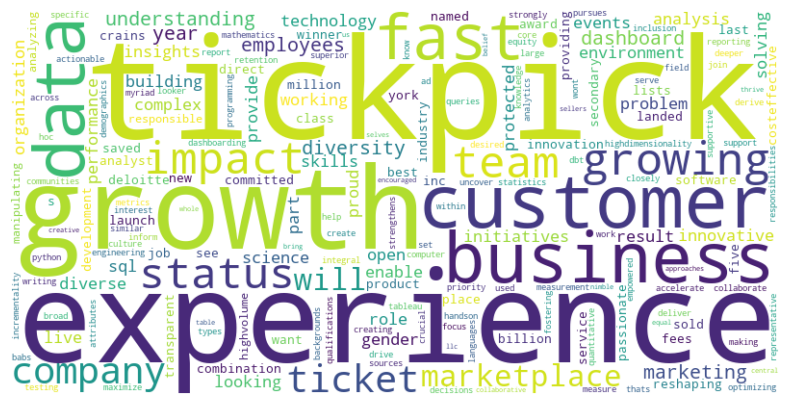

In [20]:
# Create wordcloud

# pip install wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Preprare the stopwords to exclude
stopwords = set(STOPWORDS)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text_cleaned)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()